In [7]:

from mpdaf.obj import Cube
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from astropy import units as u
from numpy import ma
import numpy as np
from astropy.table import Table, Column, MaskedColumn, pprint
from astropy.io import fits
from astropy.wcs import WCS
from mpdaf.obj import Image
from scipy import integrate

# data array is read from the file (extension number 0)
cube_26 = Cube(filename='/Users/s2537809/MUSE/cube_26.fits')

cube_27 = Cube(filename='/Users/s2537809/MUSE/cube_27.fits')

cube_28 = Cube(filename='/Users/s2537809/MUSE/cube_28.fits')

with open('HST_ACS_HRC.F606W.dat', 'r') as file:
    HST = file.read()


# Split the data into lines
HST = HST.split('\n')

# Split each line into columns and filter out any lines that don't have 2 columns
rows = [row.split() for row in HST if len(row.split()) == 2]

HST_table = Table(rows=rows, names=['Wavelength', 'Throughput'])

HST_k = np.array(HST_table['Wavelength']).astype(float)
HST_w = np.array(HST_table['Throughput']).astype(float)





In [8]:
def bandpass_image(self, wavelengths, sensitivities, unit_wave=u.angstrom,
                       interpolation="linear"):
        """
        bandpass_image sums the images of a cube after multiplying the cube by a given spectral bandpass curve.
        
        
        Given a cube of images versus wavelength and the bandpass
        filter-curve of a wide-band monochromatic instrument, extract
        an image from the cube that has the spectral response of the
        monochromatic instrument.

        For example, this can be used to create a MUSE image that has
        the same spectral characteristics as an HST image. The MUSE
        image can then be compared to the HST image without having to
        worry about any differences caused by different spectral
        sensitivities.

        For each channel n of the cube, the filter-curve is integrated
        over the width of that channel to obtain a weight, w[n]. The
        output image is then given by the following weighted mean::

            output_image = sum(w[n] * cube_image[n]) / sum(w[n])

        In practice, to accommodate masked pixels, the w[n] array is
        expanded into a cube w[n,y,x], and the weights of individual
        masked pixels in the cube are zeroed before the above equation
        is applied.

        If the wavelength axis of the cube only partly overlaps the
        bandpass of the filter-curve, the filter curve is truncated to
        fit within the bounds of the wavelength axis. A warning is
        printed to stderr if this occurs, because this results in an
        image that lacks flux from some of the wavelengths of the
        requested bandpass.

        Parameters
        ----------
        wavelengths : numpy.ndarray
            An array of the wavelengths of the filter curve,
            listed in ascending order of wavelength. Outside
            the listed wavelengths the filter-curve is assumed
            to be zero.
        sensitivities : numpy.ndarray
            The relative flux sensitivities at the wavelengths
            in the wavelengths array. These sensititivies will be
            normalized, so only their relative values are important.
        unit_wave : `astropy.units.Unit`
            The units used in the array of wavelengths. The default is
            angstroms. To specify pixel units, pass None.
        interpolation : str
            The form of interpolation to use to integrate over the
            filter curve. This should be one of::

              "linear"     : Linear interpolation
              "cubic"      : Cubic spline interpolation (very slow)

            The default is linear interpolation. If the filter curve
            is well sampled and its sampling interval is narrower than
            the wavelength pixels of the cube, then this should be
            sufficient. Alternatively, if the sampling interval is
            significantly wider than the wavelength pixels of the
            cube, then cubic interpolation should be used instead.
            Beware that cubic interpolation is much slower than linear
            interpolation.

        Returns
        -------
        `~mpdaf.obj.Image`
            An image formed from the filter-weighted mean of channels in
            the cube that overlap the bandpass of the filter curve.

        """
        from scipy import integrate

        wavelengths = np.asarray(wavelengths, dtype=float)
        sensitivities = np.asarray(sensitivities, dtype=float)

        if (wavelengths.ndim != 1 or sensitivities.ndim != 1 or
                len(wavelengths) != len(sensitivities)):
            raise ValueError('The wavelengths and sensititivies arguments'
                             ' should be 1D arrays of equal length')

        if unit_wave is None:
            pixels = wavelengths.copy()
        else:
            pixels = self.wave.pixel(wavelengths, unit=unit_wave)

        # Get the integer indexes of the pixels that contain the above
        # floating point pixel indexes.
        print(pixels)
        indexes = np.rint(pixels).astype(int)
        print(indexes)

        # If there is no overlap between the bandpass filter curve
        # and the wavelength coverage of the cube, complain.
        if indexes[0] >= self.shape[0] or indexes[-1] < 0:
            raise ValueError("The filter curve does not overlap the "
                             "wavelength coverage of the cube.")

        # To correctly reproduce an image taken through a specified
        # filter, the bandpass curve should be completely encompassed
        # by the wavelength axis of the cube. If the overlap is
        # incomplete, emit a warning, then truncate the bandpass curve
        # to the edge of the wavelength range of the cube.
        if indexes[0] < 0 or indexes[-1] >= self.shape[0]:

            # Work out the start and stop indexes of the slice needed
            # to truncate the arrays of the bandpass filter curve.
            if indexes[0] < 0:
                start = np.searchsorted(indexes, 0, 'left')
            else:
                start = 0
            if indexes[-1] >= self.shape[0]:
                stop = np.searchsorted(indexes, self.shape[0], 'left')
            else:
                stop = indexes.shape[0]

            # Integrate the overal bandpass filter curve.
            total = integrate.trapz(sensitivities, wavelengths)

            # Also integrate over just the truncated parts of the curve.
            lost = 0.0
            if start > 0:
                s = slice(0, start)
                lost += integrate.trapz(sensitivities[s], wavelengths[s])
            if stop < indexes.shape[0]:
                s = slice(stop, indexes.shape[0])
                lost += integrate.trapz(sensitivities[s], wavelengths[s])

            # Compute the fraction of the integrated bandpass response
            # that has been truncated.
            lossage = lost / total

            # Truncate the bandpass filter curve.
            indexes = indexes[start:stop]
            pixels = pixels[start:stop]
            sensitivities = sensitivities[start:stop]

            # Report the loss if it is over 0.5%.
            if lossage > 0.005:
                self._logger.warning(
                    "%.2g%% of the integrated " % (lossage * 100.0) +
                    "filter curve is beyond the edges of the cube.")

        # Get the range of indexes along the wavelength axis that
        # encompass the filter bandpass within the cube.
        kmin = indexes[0]
        kmax = indexes[-1]
        print('Len(k):', kmax - kmin + 1) 
        print(start)
        print(stop)
        print('Subcube k start:', self.wave.coord(kmin))
        print('Subcube k stop:', self.wave.coord(kmax)) #  not sure this is actually how it is being used 
        
        


        # Obtain an interpolator of the bandpass curve.
        spline = interp1d(x=pixels, y=sensitivities,
                                      kind=interpolation)

        # Integrate the bandpass over the range of each spectral pixel
        # to determine the weights of each pixel. For the moment skip
        # the first and last pixels, which need special treatment.
        # Integer pixel indexes refer to the centers of pixels,
        # so for integer pixel index k, we need to integrate from
        # k-0.5 to k+0.5.
        w = np.empty((kmax + 1 - kmin))
        for k in range(kmin + 1, kmax):
            w[k - kmin], err = integrate.quad(spline, k - 0.5, k + 0.5)

        # Start the integration of the weight of the first channel
        # from the lower limit of the bandpass.
        w[0], err = integrate.quad(spline, pixels[0], kmin + 0.5)

        # End the integration of the weight of the final channel
        # at the upper limit of the bandpass.
        w[-1], err = integrate.quad(spline, kmax - 0.5, pixels[-1])

        # Normalize the weights.
        w /= w.sum()

        # Create a sub-cube of the selected channels.
        subcube = self[kmin:kmax + 1, :, :] 

        # To accommodate masked pixels, create a cube of the above
        # weights, but with masked pixels given zero weight.
        if subcube._mask is ma.nomask:
            wcube = w[:, np.newaxis, np.newaxis] * np.ones(subcube.shape)
        else:
            wcube = w[:, np.newaxis, np.newaxis] * ~subcube._mask

        # Get an image which is the sum of the weights along the spectral axis.
        wsum = wcube.sum(axis=0)

        # The output image is the weighted mean of the selected
        # channels. For each map pixel perform the following
        # calculation over spectral channels, k.
        #
        #  mean = sum(weights[k] * data[k]) / sum(weights[k]
        data = np.ma.sum(subcube.data * wcube, axis=0) / wsum

        # The variance of a weighted means is:
        #
        #  var = sum(weights[k]**2 * var[k]) / (sum(weights[k]))**2
        if subcube._var is not None:
            var = np.ma.sum(subcube.var * wcube**2, axis=0) / wsum**2
        else:
            var = False

        return Image.new_from_obj(subcube, data=data, var=var)


[-105.06171875 -104.26171875 -103.46171875 ... 2062.93828125 2063.73828125
 2064.53828125]
[-105 -104 -103 ... 2063 2064 2065]
Len(k): 2066
131
2713
Subcube k start: 4700.3271484375
Subcube k stop: 7281.5771484375


<function matplotlib.pyplot.figure(num: 'int | str | Figure | SubFigure | None' = None, figsize: 'tuple[float, float] | None' = None, dpi: 'float | None' = None, *, facecolor: 'ColorType | None' = None, edgecolor: 'ColorType | None' = None, frameon: 'bool' = True, FigureClass: 'type[Figure]' = <class 'matplotlib.figure.Figure'>, clear: 'bool' = False, **kwargs) -> 'Figure'>

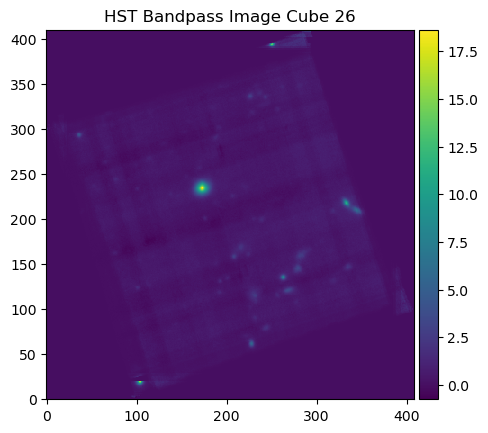

In [9]:
im26 = bandpass_image(cube_26, HST_table['Wavelength'], HST_table['Throughput']) ## Is the throughput actually good to use for sensitvities 
im26.plot(colorbar='v', title = 'HST Bandpass Image Cube 26', )
plt.figure

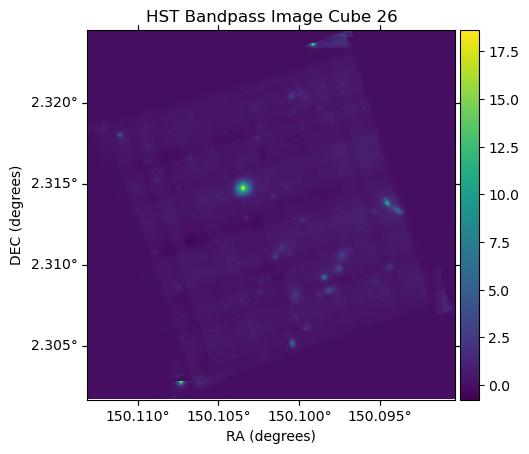

In [10]:
# Get the WCS information from the image
wcs = im26.wcs.wcs
# Plot the image using its own plot method
fig = plt.figure()
ax = fig.add_subplot(111, projection=wcs)
im26.plot(ax=ax, colorbar='v', title='HST Bandpass Image Cube 26')

ax.set_xlabel('RA (degrees)')
ax.set_ylabel('DEC (degrees)')


# Set the correct format for RA and DEC
lon = ax.coords[0]
lat = ax.coords[1]

lon.set_major_formatter('d.ddd')
lat.set_major_formatter('d.ddd')

plt.show()


In [11]:
import numpy as np
from mpdaf.obj import Cube, Image

# Assuming im26 is an Image object created from the MUSE cube
# and contains WCS information

# Get the shape of the image
shape = im26.shape

# Calculate the central pixel coordinates
central_pixel = (shape[0] // 2, shape[1] // 2)

# Get the WCS information from the image
wcs = im26.wcs.wcs

# Convert the central pixel coordinates to world coordinates (RA, Dec)
central_coord = wcs.all_pix2world(central_pixel[1], central_pixel[0], 0)

# Extract RA and Dec
ra = central_coord[0]
dec = central_coord[1]

print(f"Central RA: {ra} degrees")
print(f"Central Dec: {dec} degrees")

# Extract RA and Dec in arcsec
ra_arcsec = central_coord[0] * 3600
dec_arcsec = central_coord[1] * 3600

print(f"Central RA: {ra_arcsec} arcsec")
print(f"Central Dec: {dec_arcsec} arcsec")


# Assuming `wcs` is your WCS object
cd_matrix = wcs.wcs.cd

# Extract the CD1_1 value
cd1_1 = cd_matrix[0, 0]

print("CD1_1 value:", cd1_1)

print(wcs[0])

Central RA: 150.10172310036708 degrees
Central Dec: 2.3130871151093246 degrees
Central RA: 540366.2031613215 arcsec
Central Dec: 8327.11361439357 arcsec
CD1_1 value: -5.55555555555556e-05
SlicedFITSWCS Transformation

This transformation has 1 pixel and 2 world dimensions

Array shape (Numpy order): (409,)

Pixel Dim  Axis Name  Data size  Bounds
        0  None             409  None

World Dim  Axis Name  Physical Type  Units
        0  None       pos.eq.ra      deg
        1  None       pos.eq.dec     deg

Correlation between pixel and world axes:

           Pixel Dim
World Dim    0
        0  yes
        1  yes


In [12]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
import matplotlib.pyplot as plt
from mpdaf.obj import Cube, Image

# Specify the path to your FITS file
fits_file = 'primer_cosmos_acswfc_f435w_30mas_sci.fits.gz'

# Open the FITS file
with fits.open(fits_file) as hdul:
    # Print the information about the FITS file
    hdul.info()
    
    # Get the primary header and data
    primary_header = hdul[0].header
    image_data = hdul[0].data

    # Get the WCS information
    wcs_hst = WCS(primary_header)

# Assuming im26 is an Image object created from the MUSE cube
# and contains WCS information

# Get the shape of the MUSE image
shape_muse = im26.shape

# Calculate the central pixel coordinates of the MUSE image
central_pixel_muse = (shape_muse[0] // 2, shape_muse[1] // 2)



Filename: primer_cosmos_acswfc_f435w_30mas_sci.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    6152   (26000, 44100)   float32   
  1  HDRTAB        1 BinTableHDU    633   316R x 312C   [9A, 3A, K, D, D, D, D, D, D, D, D, D, D, D, D, D, K, 8A, 9A, 7A, 18A, 4A, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, K, 8A, 23A, D, D, D, D, K, K, K, 8A, K, 23A, 9A, 20A, K, 4A, K, D, K, K, K, K, 23A, D, D, D, D, K, K, 3A, 3A, 4A, 7A, L, D, D, D, 23A, 1A, K, D, D, D, 13A, 3A, 4A, 4A, 12A, 12A, 23A, 8A, 23A, 10A, 10A, D, D, 3A, 3A, 23A, 4A, 8A, 7A, 23A, D, K, D, 11A, 9A, 8A, D, D, L, 9A, 18A, 3A, K, 7A, 5A, 3A, D, 13A, 8A, 4A, 3A, L, K, L, K, L, K, K, D, D, D, D, D, D, 3A, 1A, D, 23A, D, D, D, 3A, 23A, L, 1A, 3A, 6A, D, 3A, 6A, K, D, D, D, D, D, D, D, D, D, D, 23A, D, D, D, D, 3A, D, D, D, 1A, K, K, K, K, K, K, 23A, K, 5A, 7A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 13A, D, 24A, 23A, D, 2A, 8A, D, K, D, D, 6A, 13A, D, 20A, K, D

In [13]:
print('Central pixel:', central_pixel_muse)

Central pixel: (205, 204)


Filename: primer_cosmos_acswfc_f435w_30mas_sci.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    6152   (26000, 44100)   float32   
  1  HDRTAB        1 BinTableHDU    633   316R x 312C   [9A, 3A, K, D, D, D, D, D, D, D, D, D, D, D, D, D, K, 8A, 9A, 7A, 18A, 4A, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, K, 8A, 23A, D, D, D, D, K, K, K, 8A, K, 23A, 9A, 20A, K, 4A, K, D, K, K, K, K, 23A, D, D, D, D, K, K, 3A, 3A, 4A, 7A, L, D, D, D, 23A, 1A, K, D, D, D, 13A, 3A, 4A, 4A, 12A, 12A, 23A, 8A, 23A, 10A, 10A, D, D, 3A, 3A, 23A, 4A, 8A, 7A, 23A, D, K, D, 11A, 9A, 8A, D, D, L, 9A, 18A, 3A, K, 7A, 5A, 3A, D, 13A, 8A, 4A, 3A, L, K, L, K, L, K, K, D, D, D, D, D, D, 3A, 1A, D, 23A, D, D, D, 3A, 23A, L, 1A, 3A, 6A, D, 3A, 6A, K, D, D, D, D, D, D, D, D, D, D, 23A, D, D, D, D, 3A, D, D, D, 1A, K, K, K, K, K, K, 23A, K, 5A, 7A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 13A, D, 24A, 23A, D, 2A, 8A, D, K, D, D, 6A, 13A, D, 20A, K, D

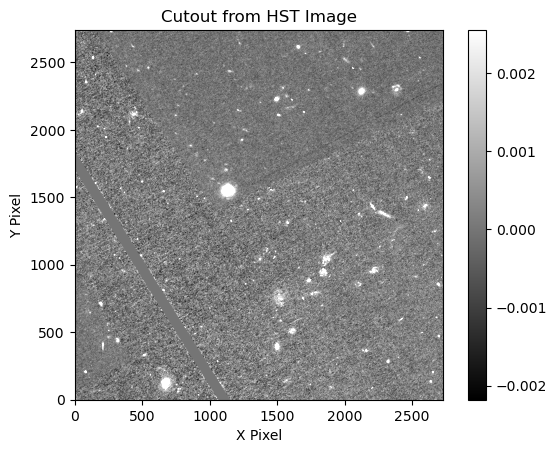

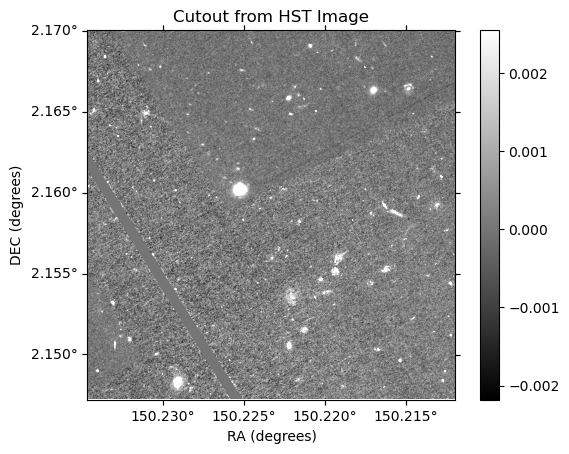

In [14]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
import matplotlib.pyplot as plt
from mpdaf.obj import Cube, Image

# Specify the path to your FITS file
fits_file = 'primer_cosmos_acswfc_f435w_30mas_sci.fits.gz'

# Open the FITS file
with fits.open(fits_file) as hdul:
    # Print the information about the FITS file
    hdul.info()
    
    # Get the primary header and data
    primary_header = hdul[0].header
    image_data = hdul[0].data

    # Get the WCS information
    wcs_hst = WCS(primary_header)

# Assuming im26 is an Image object created from the MUSE cube
# and contains WCS information

# Get the shape of the MUSE image
shape_muse = im26.shape

# Calculate the central pixel coordinates of the MUSE image
central_pixel_muse = (shape_muse[0] // 2, shape_muse[1] // 2)

# Get the WCS information from the MUSE image
wcs_muse = im26.wcs.wcs

# Convert the central pixel coordinates to world coordinates (RA, Dec)
central_coord_muse = wcs_muse.all_pix2world(central_pixel_muse[1], central_pixel_muse[0], 0)
ra_muse, dec_muse = central_coord_muse[0], central_coord_muse[1]

# Calculate the size of the MUSE image in world coordinates (degrees)
# Convert the pixel corners to world coordinates and calculate the differences
corner1 = wcs_muse.all_pix2world(0, 0, 0)
corner2 = wcs_muse.all_pix2world(shape_muse[1], shape_muse[0], 0)
width_deg = abs(corner2[0] - corner1[0])
height_deg = abs(corner2[1] - corner1[1])

print(f"Central RA: {ra_muse} degrees")
print(f"Central Dec: {dec_muse} degrees")   
print(f"Width: {width_deg} degrees")
print(f"Height: {height_deg} degrees")
print(f"corner1: {corner1} degrees")
print(f"corner2: {corner2} degrees")

# Convert the size from degrees to pixel units in the HST image
pixel_scale_hst = wcs_hst.proj_plane_pixel_scales()
width_pix = (width_deg / pixel_scale_hst[0]).value
height_pix = (height_deg / pixel_scale_hst[1]).value

# Convert the central world coordinates to pixel coordinates in the HST image
central_pixel_hst = wcs_hst.world_to_pixel_values(ra_muse, dec_muse)

# Converrt the central pixel coordinates to RA and DEC
central_coord_hst = wcs_hst.all_pix2world(central_pixel_hst[0], central_pixel_hst[1], 0)
ra_hst, dec_hst = central_coord_hst[0], central_coord_hst[1]

print(f"Central RA: {ra_hst} degrees")
print(f"Central Dec: {dec_hst} degrees") # at this point the coords are the same as muse

print (central_pixel_hst)

# Create the cutout with the calculated size in pixels
size_cutout = (int(height_pix), int(width_pix))
cutout = Cutout2D(image_data, position=central_pixel_hst, size=size_cutout, wcs=wcs_hst)

shape_cutout = cutout.data.shape
central_pixel_cutout = (shape_cutout[0] // 2, shape_cutout[1] // 2)
ra_cutout, dec_cutout = wcs_hst.all_pix2world(central_pixel_cutout[1], central_pixel_cutout[0], 0)
print(f"Central RA: {ra_cutout} degrees")
print(f"Central Dec: {dec_cutout} degrees")


# Use the WCS of the cutout for querying the central pixel coordinates
wcs_cutout = cutout.wcs
shape_cutout = cutout.data.shape
central_pixel_cutout = (shape_cutout[0] // 2, shape_cutout[1] // 2)
ra_cutout, dec_cutout = wcs_cutout.all_pix2world(central_pixel_cutout[1], central_pixel_cutout[0], 0)
print(f"Central RA: {ra_cutout} degrees")
print(f"Central Dec: {dec_cutout} degrees")



# Compute the percentiles to adjust contrast
vmin = np.percentile(cutout.data, 5)
vmax = np.percentile(cutout.data, 95)

# Plot the cutout
plt.imshow(cutout.data, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
plt.title('Cutout from HST Image')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.colorbar()
plt.show()

# Optionally, save the cutout to a new FITS file
hdu = fits.PrimaryHDU(data=cutout.data, header=cutout.wcs.to_header())
hdu.writeto('hst_cutout.fits', overwrite=True)

wcs = wcs_hst

# Compute the percentiles to adjust contrast
vmin = np.percentile(cutout.data, 5)
vmax = np.percentile(cutout.data, 95)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection=wcs)
im = ax.imshow(cutout.data, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=ax, orientation='vertical')

ax.set_title('Cutout from HST Image')
ax.set_xlabel('RA (degrees)')
ax.set_ylabel('DEC (degrees)')

# Set the format of the tick labels to degrees
lon = ax.coords[0]
lat = ax.coords[1]

lon.set_major_formatter('d.ddd')
lat.set_major_formatter('d.ddd')

plt.show()

In [15]:
print(cutout.data)
print(cutout.wcs)

[[-9.9068438e-04 -1.3248668e-03 -5.0384915e-05 ...  1.2237882e-03
  -7.0145651e-04  2.6289566e-04]
 [-6.5379671e-04 -1.1781200e-03 -1.5084938e-03 ... -3.7565370e-04
   2.0773257e-03  3.2174680e-03]
 [-2.1268607e-03 -1.1377047e-03  3.7273590e-04 ...  2.4899231e-05
   1.1324371e-03  2.4337408e-03]
 ...
 [ 6.2419393e-04  2.0983892e-03  1.1077438e-03 ... -4.4999433e-05
  -5.9888733e-04 -6.5168616e-04]
 [ 8.5526233e-04  2.5770625e-03  2.0319161e-03 ...  2.7889331e-04
  -7.0625392e-04 -5.0965161e-04]
 [ 2.6495946e-03  2.1214767e-03  1.4716525e-03 ... -5.1875814e-04
  -3.9426747e-04 -9.0929308e-05]]
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 150.1262529167  2.330972222222  
CRPIX : -1576.5  3516.5  
CD1_1 CD1_2  : -8.333333333333e-06  0.0  
CD2_1 CD2_2  : 0.0  8.333333333333e-06  
NAXIS : 2728  2740


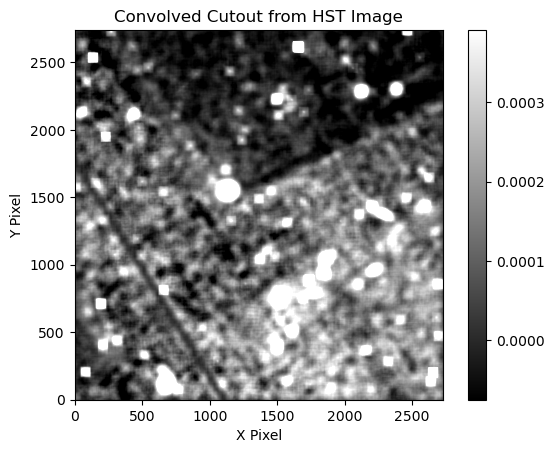

In [16]:
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import Moffat2DKernel

def convolve_image(image_data_hst, kernel):
    """
    Convolve the HST image with a given kernel.

    Parameters
    ----------
    image_data_hst : np.ndarray
        The data array of the HST image.

    kernel : astropy.convolution.Kernel2D
        The kernel to convolve the image with.

    Returns
    -------
    convolved_image : np.ndarray
        The convolved image.

    """

    # Convolve the image with the kernel
    convolved_image = convolve(image_data_hst, kernel)

    return convolved_image

# Define a Gaussian kernel with a standard deviation of 2 pixels
stddev = 2  # Standard deviation of the Gaussian kernel

# Create the Gaussian kernel
kernel_G = Gaussian2DKernel(stddev)

# Define a Moffat kernel with a FWHM of 0.3 pixels and a shape parameter of 2.5
fwhm = 0.3  # FWHM of the Moffat kernel in pixels
gamma = 2.5  # Shape parameter of the Moffat kernel

# Calculate alpha
alpha = fwhm / (2 * np.sqrt(2**(1/gamma) - 1))

# Create the Moffat kernel
kernel_M = Moffat2DKernel(gamma=gamma, alpha=alpha)

# Convolve the HST image with the Gaussian kernel

convolved_image = convolve_image(cutout.data, kernel_M)

# Compute the percentiles to adjust contrast
vmin_conv = np.percentile(convolved_image, 5)
vmax_conv = np.percentile(convolved_image, 95)

# Plot the convolved image  
plt.imshow(convolved_image, origin='lower', cmap='gray', vmin=vmin_conv, vmax=vmax_conv)
plt.title('Convolved Cutout from HST Image')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.colorbar()
plt.show()




In [17]:
data = convolved_image
print (data)

# maybe the background substraction is the problem -is this provided in muse?
from photutils.background import Background2D, MedianBackground
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50,50), filter_size=(3, 3),
                   bkg_estimator=bkg_estimator)
data -= bkg.background  # subtract the background

threshold = 4 * bkg.background_rms # Needing to adjust massively to the muse one 


from photutils.segmentation import detect_sources
segment_map = detect_sources(data, threshold, npixels=5)
print(segment_map)

[[ 7.3175193e-05  7.3746160e-05  7.7612705e-05 ...  6.6200744e-05
   6.6189641e-05  6.4777727e-05]
 [ 7.4399519e-05  7.5388591e-05  7.9709505e-05 ...  7.2023446e-05
   7.1809271e-05  7.0281778e-05]
 [ 7.5553224e-05  7.6960074e-05  8.1566686e-05 ...  7.4621021e-05
   7.4116761e-05  7.2346003e-05]
 ...
 [ 2.3074443e-05  2.1318112e-05  2.0489222e-05 ... -1.8505481e-05
  -1.7187986e-05 -1.5513566e-05]
 [ 2.0408630e-05  1.8680777e-05  1.7648046e-05 ... -2.0605359e-05
  -1.9202740e-05 -1.7653729e-05]
 [ 1.6904496e-05  1.5224553e-05  1.4223695e-05 ... -2.0651507e-05
  -1.9328574e-05 -1.7882954e-05]]
<photutils.segmentation.core.SegmentationImage>
shape: (2740, 2728)
nlabels: 264
labels: [  1   2   3   4   5 ... 260 261 262 263 264]


Text(0.5, 1.0, 'Segmentation Image')

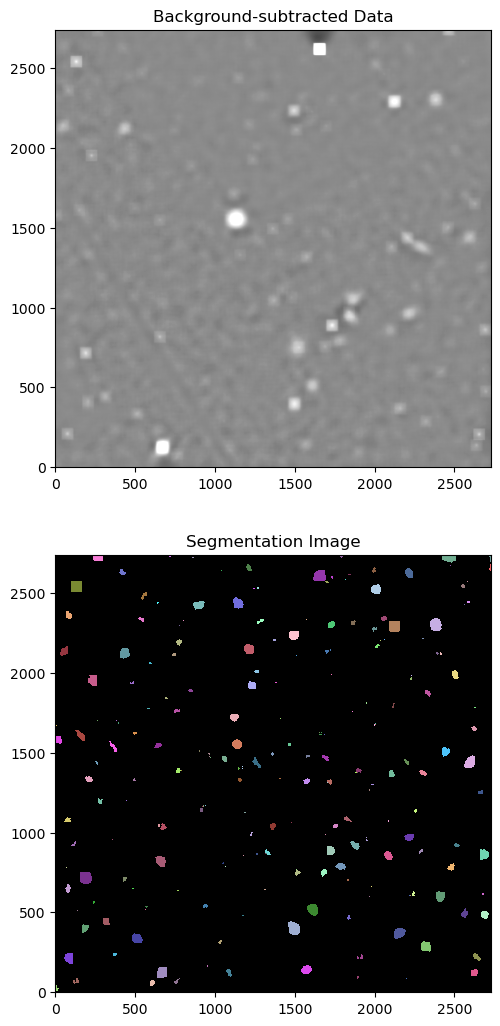

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', vmin=vmin, vmax=vmax,)
ax1.set_title('Background-subtracted Data')
ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap,
           interpolation='nearest')
ax2.set_title('Segmentation Image')

[-105.14765625 -104.34765625 -103.54765625 ... 2062.85234375 2063.65234375
 2064.45234375]
[-105 -104 -104 ... 2063 2064 2064]
Len(k): 2065
131
2713
Subcube k start: 4700.4345703125
Subcube k stop: 7280.4345703125


<function matplotlib.pyplot.figure(num: 'int | str | Figure | SubFigure | None' = None, figsize: 'tuple[float, float] | None' = None, dpi: 'float | None' = None, *, facecolor: 'ColorType | None' = None, edgecolor: 'ColorType | None' = None, frameon: 'bool' = True, FigureClass: 'type[Figure]' = <class 'matplotlib.figure.Figure'>, clear: 'bool' = False, **kwargs) -> 'Figure'>

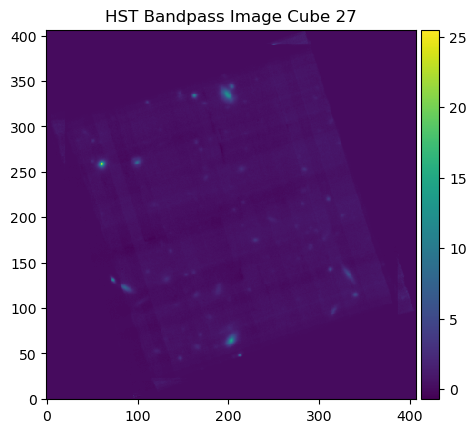

In [19]:
im27 = bandpass_image(cube_27, HST_table['Wavelength'], HST_table['Throughput']) ## Is the throughput actually good to use for sensitvities 
im27.plot(colorbar='v', title = 'HST Bandpass Image Cube 27', )
plt.figure


[-105.14960938 -104.34960938 -103.54960938 ... 2062.85039063 2063.65039062
 2064.45039063]
[-105 -104 -104 ... 2063 2064 2064]
Len(k): 2065
131
2713
Subcube k start: 4700.43701171875
Subcube k stop: 7280.43701171875


<function matplotlib.pyplot.figure(num: 'int | str | Figure | SubFigure | None' = None, figsize: 'tuple[float, float] | None' = None, dpi: 'float | None' = None, *, facecolor: 'ColorType | None' = None, edgecolor: 'ColorType | None' = None, frameon: 'bool' = True, FigureClass: 'type[Figure]' = <class 'matplotlib.figure.Figure'>, clear: 'bool' = False, **kwargs) -> 'Figure'>

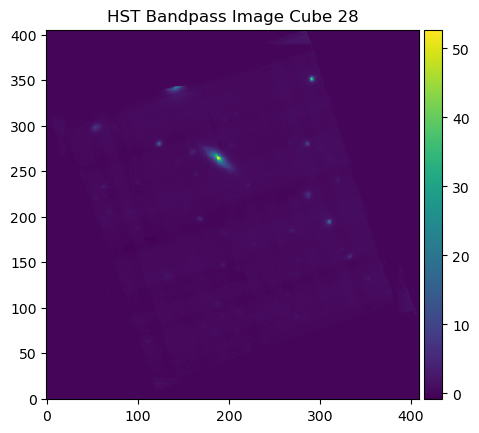

In [20]:

im28 = bandpass_image(cube_28, HST_table['Wavelength'], HST_table['Throughput']) ## Is the throughput actually good to use for sensitvities 
im28.plot(colorbar='v', title = 'HST Bandpass Image Cube 28', )
plt.figure


In [21]:
import numpy as np
import numpy as np
print(type(im26))
im26_array = im26.data


# the botttom plot seems to not change when the source catalog is changed 

print(type(im26_array))

zero_values_exist = np.any(im26_array == 0.0)
print(zero_values_exist)

zero_values_count = np.count_nonzero(im26_array == 0.0)
print(zero_values_count)



<class 'mpdaf.obj.image.Image'>
<class 'numpy.ma.core.MaskedArray'>
True
72862


In [22]:
# Replace all 0.0 values with NaN
im26_array = np.where((im26_array == 0.0), np.nan, im26_array)
im27_array = np.where((im27.data == 0.0), np.nan, im27.data)
im28_array = np.where((im28.data == 0.0), 0., im28.data)



[[0. 0. 0. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0. 0. 0.]]
(406, 409)


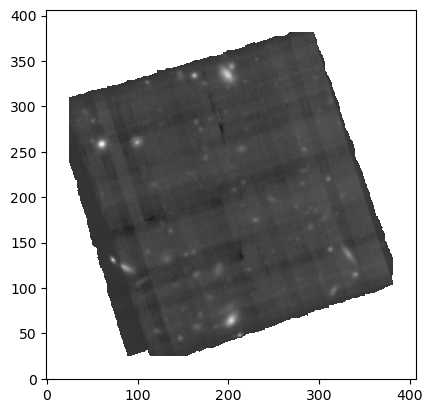

In [23]:

import numpy as np
from scipy.ndimage import rotate


# Create a square array
square = np.ones((10, 10))

# Rotate the square by 40 degrees
rotated_square = rotate(square, angle=20, reshape=False)

# Print the shape of the rotated square
print(rotated_square)


from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy import ndimage
norm = ImageNormalize(stretch=SqrtStretch())

print(im28_array.shape)

im28_e = ndimage.binary_erosion(im27_array, iterations=25)

im28_array_masked = np.where(im28_e == False, np.nan, im27_array)

plt.imshow(im28_array_masked, origin='lower', cmap='Greys_r', norm=norm)


In [24]:
import numpy as np
# Get the WCS information
wcs = WCS(primary_header)


In [25]:
from photutils.datasets import make_100gaussians_image
data = im28_array
print (data)

# maybe the background substraction is the problem -is this provided in muse?
from photutils.background import Background2D, MedianBackground
bkg_estimator = MedianBackground()
bkg = Background2D(data, (30,30), filter_size=(3, 3),
                   bkg_estimator=bkg_estimator)
data -= bkg.background  # subtract the background

threshold = 2 * bkg.background_rms

from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0
convolved_data = convolve(data, kernel)

from photutils.segmentation import detect_sources
segment_map = detect_sources(convolved_data, threshold, npixels=5)
print(segment_map)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<photutils.segmentation.core.SegmentationImage>
shape: (406, 409)
nlabels: 83
labels: [ 1  2  3  4  5 ... 79 80 81 82 83]


Text(0.5, 1.0, 'Segmentation Image')

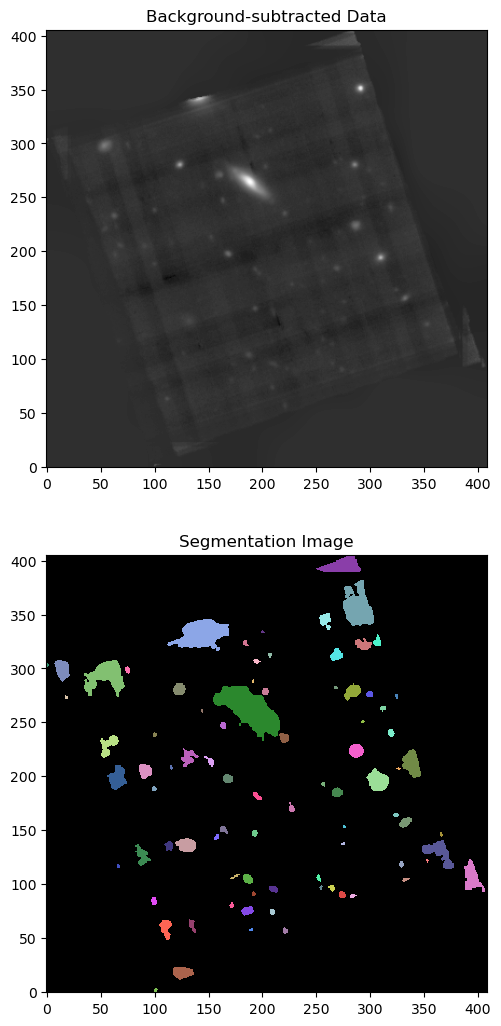

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Background-subtracted Data')
ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap,
           interpolation='nearest')
ax2.set_title('Segmentation Image')


In [27]:
from photutils.segmentation import deblend_sources
segm_deblend = deblend_sources(convolved_data, segment_map,
                               npixels=10, nlevels=32, contrast=0.001,
                               progress_bar=False)

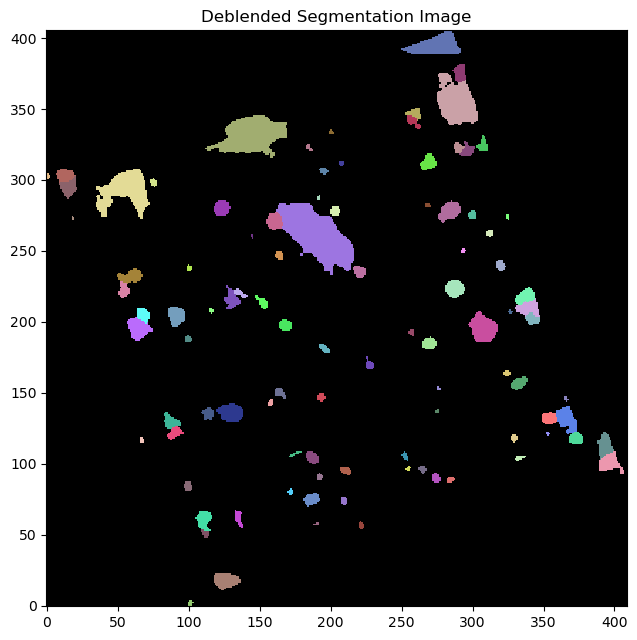

In [28]:
norm = ImageNormalize(stretch=SqrtStretch())
fig, ax = plt.subplots(1, 1, figsize=(10, 6.5))
ax.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap,
          interpolation='nearest')
ax.set_title('Deblended Segmentation Image')
plt.tight_layout()


In [29]:
from photutils.segmentation import SourceFinder
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(convolved_data, threshold)
print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (406, 409)
nlabels: 83
labels: [ 1  2  3  4  5 ... 79 80 81 82 83]


In [30]:
from photutils.segmentation import SourceFinder
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(convolved_data, threshold)
print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (406, 409)
nlabels: 83
labels: [ 1  2  3  4  5 ... 79 80 81 82 83]


In [31]:
from photutils.segmentation import SourceCatalog
cat = SourceCatalog(data, segm_deblend, convolved_data=convolved_data)
print(cat)

<photutils.segmentation.catalog.SourceCatalog>
Length: 98
labels: [ 1  2  3  4  5 ... 94 95 96 97 98]


In [32]:
tbl = cat.to_table()
tbl['xcentroid'].info.format = '.2f'  # optional format
tbl['ycentroid'].info.format = '.2f'
tbl['kron_flux'].info.format = '.2f'
print(tbl)

label xcentroid ycentroid ... segment_fluxerr kron_flux kron_fluxerr
                          ...                                       
----- --------- --------- ... --------------- --------- ------------
    1    101.19      1.42 ...             nan      7.77          nan
    2    125.60     17.32 ...             nan    117.32          nan
    3    221.36     56.32 ...             nan     13.71          nan
    4    135.09     61.19 ...             nan     99.02          nan
    5    189.81     57.33 ...             nan     25.40          nan
    6    186.52     74.71 ...             nan    196.05          nan
    7    209.42     73.60 ...             nan     28.98          nan
    8    171.78     79.85 ...             nan     25.71          nan
    9     99.52     83.88 ...             nan     54.49          nan
   10    274.20     89.81 ...             nan     73.90          nan
  ...       ...       ... ...             ...       ...          ...
   89    188.69    263.20 ...     

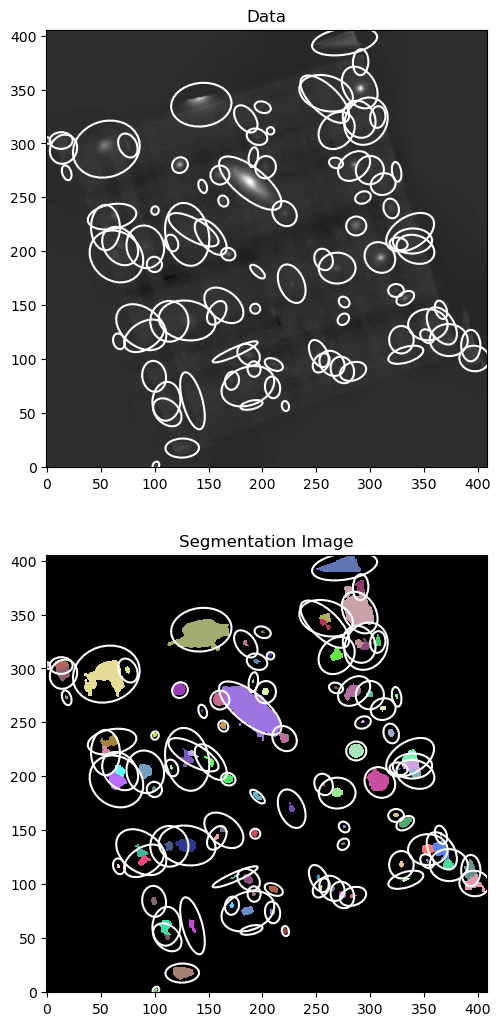

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
ax2.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap,
           interpolation='nearest')
ax2.set_title('Segmentation Image')
cat.plot_kron_apertures(ax=ax1, color='white', lw=1.5)
cat.plot_kron_apertures(ax=ax2, color='white', lw=1.5)

In [34]:
cat = SourceCatalog(data, segm_deblend, convolved_data=convolved_data)
labels = [1, 5, 20, 50, 75, 80]
cat_subset = cat.get_labels(labels)
tbl2 = cat_subset.to_table()
tbl2['xcentroid'].info.format = '.2f'  # optional format
tbl2['ycentroid'].info.format = '.2f'
tbl2['kron_flux'].info.format = '.2f'
print(tbl2)

label xcentroid ycentroid ... segment_fluxerr kron_flux kron_fluxerr
                          ...                                       
----- --------- --------- ... --------------- --------- ------------
    1    101.19      1.42 ...             nan      7.77          nan
    5    189.81     57.33 ...             nan     25.40          nan
   20     66.94    116.39 ...             nan      9.49          nan
   50    144.61    260.21 ...             nan     10.91          nan
   75    372.93    117.52 ...             nan    126.29          nan
   80     64.55    195.18 ...             nan    247.39          nan


In [35]:
cat = SourceCatalog(data, segm_deblend, convolved_data=convolved_data)
labels = [1, 5, 20, 50, 75, 80]
cat_subset = cat.get_labels(labels)
columns = ['label', 'xcentroid', 'ycentroid', 'area', 'segment_flux']
tbl3 = cat_subset.to_table(columns=columns)
tbl3['xcentroid'].info.format = '.4f'  # optional format
tbl3['ycentroid'].info.format = '.4f'
tbl3['segment_flux'].info.format = '.4f'
print(tbl3)

label xcentroid ycentroid  area segment_flux
                           pix2             
----- --------- --------- ----- ------------
    1  101.1879    1.4186  12.0       8.2362
    5  189.8143   57.3270   6.0       2.4060
   20   66.9412  116.3947  11.0       3.3588
   50  144.6088  260.2051   5.0       2.1992
   75  372.9334  117.5188  74.0      47.4735
   80   64.5507  195.1773 187.0      99.6095


In [36]:
cat = SourceCatalog(data, segm_deblend, background=bkg.background)
labels = [1, 5, 20, 50, 75, 80]
cat_subset = cat.get_labels(labels)
columns = ['label', 'background_centroid', 'background_mean',
           'background_sum']
tbl4 = cat_subset.to_table(columns=columns)
tbl4['background_centroid'].info.format = '{:.10f}'  # optional format
tbl4['background_mean'].info.format = '{:.10f}'
tbl4['background_sum'].info.format = '{:.10f}'
print(tbl4)

label background_centroid background_mean background_sum
----- ------------------- --------------- --------------
    1        0.0023254295    0.0677397031   0.8128764367
    5        0.1176091857    0.2593141807   1.5558850839
   20        0.1479234843    0.0346905389   0.3815959280
   50        0.5600688102    0.5377398589   2.6886992943
   75        0.0114461045    0.3604993234  26.6769499336
   80        0.2817818374    0.1709436927  31.9664705350


In [37]:
from photutils.utils import calc_total_error
effective_gain = 500.0
error = calc_total_error(data, bkg.background_rms, effective_gain)
cat = SourceCatalog(data, segm_deblend, error=error)
labels = [1, 5, 20, 50, 75, 80]
cat_subset = cat.get_labels(labels)  # select a subset of objects
columns = ['label', 'xcentroid', 'ycentroid', 'segment_flux',
           'segment_fluxerr']
tbl5 = cat_subset.to_table(columns=columns)
tbl5['xcentroid'].info.format = '{:.4f}'  # optional format
tbl5['ycentroid'].info.format = '{:.4f}'
tbl5['segment_flux'].info.format = '{:.4f}'
tbl5['segment_fluxerr'].info.format = '{:.4f}'
for col in tbl5.colnames:
    tbl5[col].info.format = '%.8g'  # for consistent table output
print(tbl5)

label xcentroid ycentroid segment_flux segment_fluxerr
----- --------- --------- ------------ ---------------
    1 101.03087 1.4676322    8.2362092      0.47786694
    5 189.92528  57.35197     2.405951      0.36806616
   20 66.909084 116.36414    3.3588435      0.32334842
   50 144.67274 260.12823    2.1992327      0.34775215
   75  373.1333 117.50321    47.473536       2.0255448
   80 64.531772 195.12725    99.609508        2.511829


# As Functions

In [77]:
# Imports necessary for Source Catalog
from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
from photutils.segmentation import detect_sources
from photutils.segmentation import deblend_sources
from photutils.segmentation import SourceFinder
from photutils.segmentation import SourceCatalog
from scipy.ndimage import binary_erosion

# Imports necessary for visulisation
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import simple_norm

In [31]:
from numpy import savetxt
im26_data = im26.data
# save to csv file
savetxt('im26_data.csv', im26_data, delimiter=',')


im27_data = im27.data
# save to csv file
savetxt('im27_data.csv', im27_data, delimiter=',')

im28_data = im28.data
# save to csv file
savetxt('im28_data.csv', im28_data, delimiter=',')



print(im26_data.shape)


(411, 409)
(411, 409)


In [37]:


# Save WCS and image data to FITS function
def save_wcs_to_fits(im_data, wcs_object, fits_filename):
    hdu = fits.PrimaryHDU(im_data.filled())
    hdu.header.extend(wcs_object.to_header(), update=True)
    hdu.writeto(fits_filename, overwrite=True)


# Example usage for each bandpass cube
save_wcs_to_fits(im26.data, im26.wcs, 'im26_wcs.fits')
save_wcs_to_fits(im27.data, im27.wcs, 'im27_wcs.fits')
save_wcs_to_fits(im28.data, im28.wcs, 'im28_wcs.fits')

In [38]:
# Example to load WCS from a FITS file
muse_no = 26  # Example muse_no, replace with actual number

# Load the WCS information from the FITS file
fits_filename = f'im{muse_no}_wcs.fits'
with fits.open(fits_filename) as hdul:
    im_wcs = WCS(hdul[0].header)

# Optionally, you can access WCS information directly from im_wcs
print(im_wcs)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 150.101125  2.31237  
CRPIX : 215.75703465568  193.09192576559  
CD1_1 CD1_2  : -5.5555555555556e-05  0.0  
CD2_1 CD2_2  : 0.0  5.5555555555556e-05  
NAXIS : 409  411


In [33]:
print(im26.wcs)
   

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 150.101125  2.31237  
CRPIX : 215.757034655676  193.091925765594  
CD1_1 CD1_2  : -5.55555555555556e-05  0.0  
CD2_1 CD2_2  : 0.0  5.55555555555556e-05  
NAXIS : 409  411


In [27]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS

# Assuming im26 is your image object with data and WCS
im26_data = im26.data.filled(np.nan)  # Convert masked array to regular array
im26_wcs = im26.wcs if hasattr(im26, 'wcs') else WCS(im26.header)

# Save the data to a CSV file
np.savetxt('im26_data.csv', im26_data, delimiter=',')

# Save the WCS information in a FITS file
hdu = fits.PrimaryHDU(data=im26_data, header=im26_wcs.to_header())
hdul = fits.HDUList([hdu])
hdul.writeto('im26_wcs.fits', overwrite=True)

# Load the data from the CSV file
im26_data_loaded = np.loadtxt('im26_data.csv', delimiter=',')
print(im26_data_loaded.shape)

# Load the WCS information from the FITS file
with fits.open('im26_wcs.fits') as hdul:
    im26_wcs_loaded = WCS(hdul[0].header)

print(im26_wcs_loaded)

# Get the WCS information from the image
wcs_in = im26_wcs_loaded

print(wcs)

(411, 409)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 150.101125  2.31237  
CRPIX : 215.75703465568  193.09192576559  
CD1_1 CD1_2  : -5.5555555555556e-05  0.0  
CD2_1 CD2_2  : 0.0  5.5555555555556e-05  
NAXIS : 409  411
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 150.101125  2.31237  
CRPIX : 215.757034655676  193.091925765594  
CD1_1 CD1_2  : -5.55555555555556e-05  0.0  
CD2_1 CD2_2  : 0.0  5.55555555555556e-05  
NAXIS : 409  411


In [49]:
# Convert the central pixel coordinates to world coordinates (RA, Dec)
central_coord = wcs_in.all_pix2world(central_pixel[1], central_pixel[0], 0)


# Extract RA and Dec
ra = central_coord[0]
dec = central_coord[1]

print(f"Central RA: {ra} degrees")
print(f"Central Dec: {dec} degrees")


Central RA: 150.10172310036708 degrees
Central Dec: 2.3130871151093246 degrees


In [36]:

# Assuming im26 is your image object with data and WCS
im27_data = im26.data.filled(np.nan)  # Convert masked array to regular array
im27_wcs = im26.wcs if hasattr(im27, 'wcs') else WCS(im26.header)

# Save the data to a CSV file
np.savetxt('im27_data.csv', im26_data, delimiter=',')

# Save the WCS information in a FITS file
hdu = fits.PrimaryHDU(data=im27_data, header=im26_wcs.to_header())
hdul = fits.HDUList([hdu])
hdul.writeto('im27_wcs.fits', overwrite=True)


In [37]:

# Assuming im26 is your image object with data and WCS
im28_data = im28.data.filled(np.nan)  # Convert masked array to regular array
im28_wcs = im28.wcs if hasattr(im26, 'wcs') else WCS(im26.header)

# Save the data to a CSV file
np.savetxt('im28_data.csv', im28_data, delimiter=',')

# Save the WCS information in a FITS file
hdu = fits.PrimaryHDU(data=im28_data, header=im28_wcs.to_header())
hdul = fits.HDUList([hdu])
hdul.writeto('im28_wcs.fits', overwrite=True)


In [95]:


def source_catalog(data, npixels=10):


    """  

    Takes an image from the mpdaf bandpass_image function 
    (a 2d image convolved with a bandpass filter) and returns a source catalog
    of the sources in the image. 

    Parameters
    ----------
    data : np.ndarray
        The data array of the image

    npixels : int
        The number of pixels that define the minimum source size. Default is 10.

    Returns
    -------
    data : np.ndarray
        The data array of the image

    tbl : astropy.table.Table
        A table containing the source catalog

    segment_map : np.ndarray
        The segmentation map of the image

    segm_deblend : np.ndarray
        The deblended segmentation map of the image

    cat : photutils.segmentation.SourceCatalog
        The source catalog of the image


    """

    
    # Replace all 0.0 values with NaN
    data = np.where((data == 0.0), np.nan, data)


    data_e = ndimage.binary_erosion(data, iterations=25)

    data = np.where(data_e == False, np.nan, data)

    

    
    # Background substraction
    bkg_estimator = MedianBackground()
    bkg = Background2D(data, (30, 30), filter_size=(3, 3),
                    bkg_estimator=bkg_estimator)
    data -= bkg.background  # subtract the background

    # Select threshold above background at x-sigma  pixel noise level
    threshold = 2 * bkg.background_rms

    # Convolve the data with a 2d gaussian kernel
    kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0
    convolved_data = convolve(data, kernel)

    # Detect sources in the convolved data
    segment_map = detect_sources(convolved_data, threshold, npixels) # Should all the npixels be the same?
    
    # Deblend the sources
    segm_deblend = deblend_sources(convolved_data, segment_map,
                                npixels, nlevels=32, contrast=0.001,
                                progress_bar=False)

    # Find the sources
    finder = SourceFinder(npixels, progress_bar=False)
    segment_map = finder(convolved_data, threshold)

    # Create a source catalog
    cat = SourceCatalog(data, segm_deblend, convolved_data=convolved_data)
    
    # Create a table of the source catalog
    tbl = cat.to_table()
    tbl['xcentroid'].info.format = '.2f'  # optional format
    tbl['ycentroid'].info.format = '.2f'
    tbl['kron_flux'].info.format = '.2f'

    
    return data, tbl, segment_map, segm_deblend, cat 




def visulisation(segment_map, data, segm_deblend, cat):

    """
    Generates plots of the data, segmentation map and deblended segmentation map
    of the sources in the image. It also plots the sources selected in the source catalog.  
    
    This gives the visulisation of the sources selected so the selection critieria can be adjusted by eye.

    Parameters
    ----------
    segment_map : np.ndarray
        The segmentation map of the image

    data : np.ndarray   
        The data array of the image
    
    segm_deblend : np.ndarray       
        The deblended segmentation map of the image

    cat : photutils.segmentation.SourceCatalog
        The source catalog of the image
    
    Returns
    -------
    plt.show() : matplotlib.pyplot
        The plots of the data, segmentation map and deblended segmentation map of the sources in the image


    """
    
    norm = ImageNormalize(stretch=SqrtStretch())
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
    ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
    ax1.set_title('Background-subtracted Data')
    ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap,
               interpolation='nearest')
    ax2.set_title('Segmentation Image')

    norm = ImageNormalize(stretch=SqrtStretch())
    fig, ax = plt.subplots(1, 1, figsize=(10, 6.5))
    ax.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap,
              interpolation='nearest')
    ax.set_title('Deblended Segmentation Image')
    plt.tight_layout()

    norm = simple_norm(data, 'sqrt')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
    ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
    ax1.set_title('Data')
    ax2.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap,
               interpolation='nearest')
    ax2.set_title('Segmentation Image')
    cat.plot_kron_apertures(ax=ax1, color='white', lw=1.5)
    cat.plot_kron_apertures(ax=ax2, color='white', lw=1.5)

    return plt.show()

In [96]:
# Image produced at the top of the script from the bandpass_image function
source_catalog(im26_data1,10)[1]


label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,103.17,24.67,None,100,106,23,27,17.0,1.7627380505116639,1.2628635876914447,18.54184350040991,0.6976676234912447,0.10767548870421795,1.1699728984037647,0.0,10.806436234466199,nan,12.90,nan
2,135.66,60.79,None,133,139,55,66,49.0,3.251034819253241,1.2585797565442751,-70.86299014424976,0.9220242838816161,0.17970133207235475,0.4804530455860192,0.0,17.162783772382074,nan,67.09,nan
3,227.86,61.57,None,223,232,56,68,106.0,2.718430456560337,1.941598646229823,-79.81483184767399,0.699905792432268,0.17566870321331868,5.31610991347356,0.0,151.3620061649507,nan,158.34,nan
4,144.56,65.27,None,140,149,63,67,31.0,2.63717051669338,0.9277912320694449,19.11298332209713,0.9360702520061623,0.18889025017250952,0.5030725065123121,0.0,10.637891032201573,nan,113.62,nan
5,183.51,75.48,None,181,186,71,79,43.0,2.3007129124874908,1.4729025410272771,-86.52163794481154,0.7682133014089955,0.205257757522394,0.4864899561383778,0.0,15.587609821987948,nan,115.22,nan
6,137.86,74.56,None,134,143,72,77,45.0,2.4740323898633534,1.3527652901455984,20.96604132381765,0.8372726588336571,0.21296179987577527,0.5882450837542776,0.0,16.965169423072638,nan,90.78,nan
7,244.12,78.74,None,239,249,75,83,70.0,2.3474290007959278,1.8272772172372025,28.375906465340407,0.6277482919438526,0.21822457397699035,1.5695219749810099,0.0,53.0816024977015,nan,60.89,nan
8,231.85,89.87,None,229,235,87,93,35.0,1.603996393386561,1.5001451539253163,-45.74937770374968,0.35397550742458583,0.24754352931160933,1.0595124150974888,0.0,19.176252794188542,nan,43.10,nan


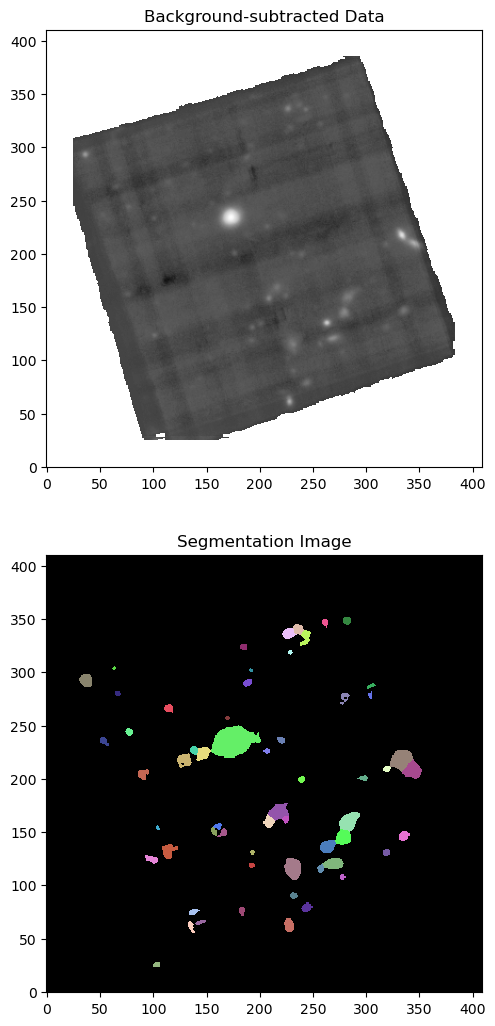

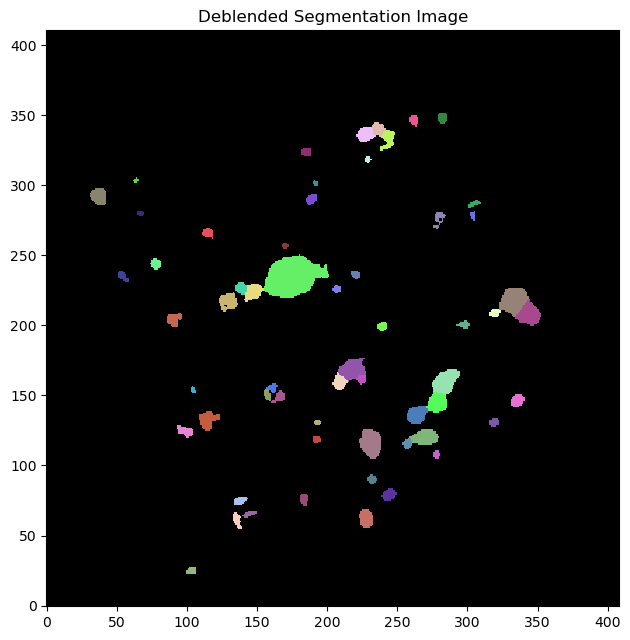

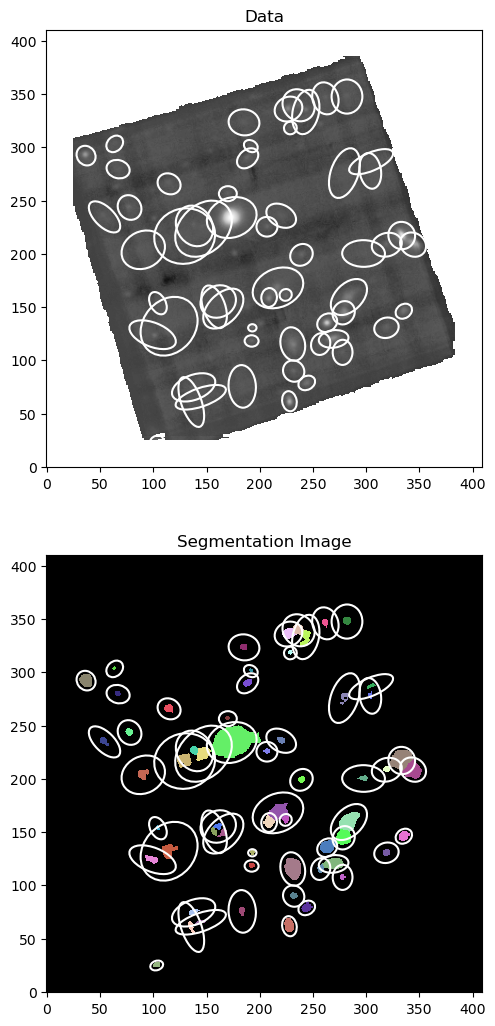

In [98]:
data, tbl, segment_map, segm_deblend, cat = source_catalog(im26_data1,10)
visulisation(segment_map, data, segm_deblend, cat)


# the botttom plot seems to not change when the source catalog is changed 

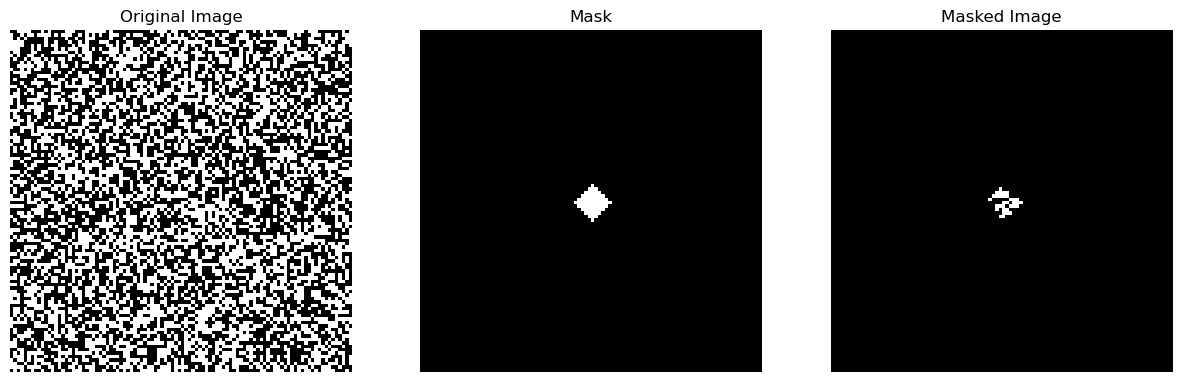

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Define the large triangular structuring element
large_structuring_element = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                      [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
                                      [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
                                      [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                                      [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                                      [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                                      [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                                      [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
                                      [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
                                      [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

# Create a dummy image for demonstration (e.g., an image of size 100x100)
image = np.random.randint(0, 2, size=(100, 100), dtype=int)

# Determine the center of the image
image_center = (image.shape[0] // 2, image.shape[1] // 2)

# Determine the offsets for placing the structuring element at the center of the image
offsets = (large_structuring_element.shape[0] // 2, large_structuring_element.shape[1] // 2)

# Create a mask of the same size as the image, initialized to zeros
mask = np.zeros_like(image)

# Place the structuring element at the center of the mask
mask[image_center[0] - offsets[0]:image_center[0] + offsets[0] + 1,
     image_center[1] - offsets[1]:image_center[1] + offsets[1] + 1] = large_structuring_element

# Apply the mask to the image
masked_image = image * mask

# Visualize the original image, the mask, and the masked image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Masked Image')
plt.imshow(masked_image, cmap='gray')
plt.axis('off')

plt.show()



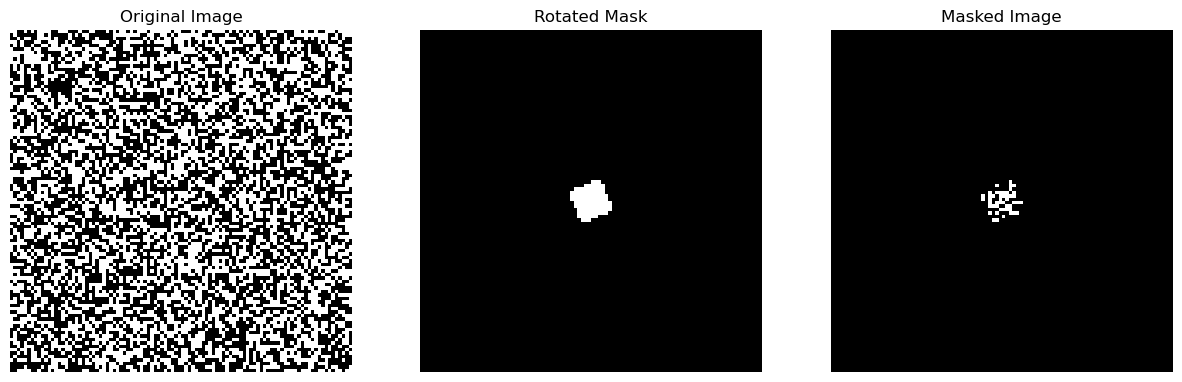

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

# Define a square structuring element
square_size = 11  # Size of the square
square_structuring_element = np.ones((square_size, square_size), dtype=int)

# Rotate the square by 40 degrees
rotated_square = rotate(square_structuring_element, angle=20, reshape=True, order=1)

# Binarize the rotated square (values will be between 0 and 1 due to rotation interpolation)
rotated_square = rotated_square > 0.5

# Create a dummy image for demonstration (e.g., an image of size 100x100)
image = np.random.randint(0, 2, size=(100, 100), dtype=int)

# Determine the center of the image
image_center = (image.shape[0] // 2, image.shape[1] // 2)

# Determine the offsets for placing the structuring element at the center of the image
offsets = (rotated_square.shape[0] // 2, rotated_square.shape[1] // 2)

# Create a mask of the same size as the image, initialized to zeros
mask = np.zeros_like(image)

# Place the structuring element at the center of the mask
mask[image_center[0] - offsets[0]:image_center[0] + offsets[0],
     image_center[1] - offsets[1]:image_center[1] + offsets[1]] = rotated_square
# Apply the mask to the image
masked_image = image * mask

# Visualize the original image, the mask, and the masked image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Rotated Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Masked Image')
plt.imshow(masked_image, cmap='gray')
plt.axis('off')

plt.show()

